stackingのアンサンブル用シート

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import scipy as sp
import lightgbm as lgb
import category_encoders as ce
# import mojimoji
import re
from cmath import nan
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import accuracy_score
import optuna
from sklearn.metrics import mean_squared_error
import japanize_matplotlib
from sklearn.linear_model import LinearRegression
import xgboost
from sklearn.model_selection import KFold

###訓練データの読み込み
house_age = pd.read_csv('house_age.csv')
area_size = pd.read_csv('area_size.csv')
room_arrange = pd.read_csv('room_arrange.csv')
contract_span = pd.read_csv('contract_span.csv')#欠損値をゼロ埋めした契約期間
contract_span2 = pd.read_csv('contract_span2.csv')#欠損値を欠損値のままにした契約期間
reg_rent = pd.read_csv('reg_rent.csv')
floor_scores = pd.read_csv('floor_scores.csv')#「所在階」と「全体の階数」が連動して欠損値になる場合のある「所在階」
floor_scores2 = pd.read_csv('floor_scores2.csv')#「所在階」と「全体の階数」が独立している「所在階」
Floor_scores = pd.read_csv('capital_floor_scores.csv')#「所在階」と「全体の階数」が連動して欠損値になる場合のある「全体の階数」
Floor_scores2 = pd.read_csv('capital_floor_scores2.csv')#「所在階」と「全体の階数」が独立している「全体の階数」
stations = pd.read_csv('stations.csv')
minits = pd.read_csv('minits.csv')
addresses = pd.read_csv('addresses.csv')
room_arrange = pd.read_csv('room_arrange.csv')
buildings = pd.read_csv('buildings.csv')

rent = pd.read_csv('rent.csv')


##テストデータの読み込み
test_house_age = pd.read_csv('test_house_age.csv')
test_area_size = pd.read_csv('test_area_size.csv')
test_room_arrange = pd.read_csv('test_room_arrange.csv')
test_contract_span = pd.read_csv('test_contract_span.csv')
test_contract_span2 = pd.read_csv('test_contract_span2.csv')
test_reg_rent = pd.read_csv('test_reg_rent.csv')
test_floor_scores = pd.read_csv('test_floor_scores.csv')
test_floor_scores2 = pd.read_csv('test_floor_scores2.csv')
test_Floor_scores = pd.read_csv('test_capital_floor_scores.csv')
test_Floor_scores2 = pd.read_csv('test_capital_floor_scores2.csv')
test_stations = pd.read_csv('test_stations.csv')
test_minits = pd.read_csv('test_minits.csv')
test_addresses = pd.read_csv('test_addresses.csv')
test_room_arrange = pd.read_csv('test_room_arrange.csv')
test_buildings = pd.read_csv('test_buildings.csv')

lightGBMとDARTとGOSSとXGBoostでstackingアンサンブルを行う。

In [29]:
X_train = pd.concat([house_age, area_size, contract_span2, reg_rent, floor_scores2, Floor_scores2, stations, minits, addresses, room_arrange[["部屋数","L","D","K","S"]]], axis=1)
y_train = rent
X_test = pd.concat([test_house_age, test_area_size, test_contract_span2, test_reg_rent, test_floor_scores2, test_Floor_scores2, test_stations, test_minits, test_addresses, test_room_arrange[["部屋数","L","D","K","S"]]], axis=1)

X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.2, random_state=0)
sX_train, sX_valid, sy_train, sy_valid = train_test_split(X_train, y_train, test_size=0.1, random_state=0)

In [30]:
category_lists = ['定期借家','最寄り駅', '所在地', 'L', 'D','K','S']

####LisgtGBM###
lgb_train = lgb.Dataset(sX_train, sy_train)
lgb_eval = lgb.Dataset(sX_valid, sy_valid, reference=lgb_train)
params_LGBM = {
    'objective':'regression',
    'metrics':'rmse',
    'learning_rate':0.01,
    'reg_lambda': 4.430375245218262e-06,
    'max_bin': 502,
    'num_leaves': 97
}
model_LGBM = lgb.train(
                    params_LGBM,
                    lgb_train, 
                    valid_sets=[lgb_train, lgb_eval], 
                    verbose_eval=10, 
                    num_boost_round=3000, 
                    early_stopping_rounds=10,
                    categorical_feature = category_lists
                    )

# ###DART###
# lgb_train = lgb.Dataset(sX_train, sy_train)
# lgb_eval = lgb.Dataset(sX_valid, sy_valid, reference=lgb_train)
# params_DART = {
#     'objective':'regression',
#     'boosting_type':'dart',
#     'metrics':'rmse',
#     'learning_rate':0.01,
#     'reg_lambda': 2.1600820741402023e-05,
#     'max_bin': 556,
#     'num_leaves': 126
# }

# model_DART = lgb.train(
#                     params_DART,
#                     lgb_train, 
#                     valid_sets=[lgb_train, lgb_eval], 
#                     verbose_eval=10, 
#                     num_boost_round=1000, 
#                     early_stopping_rounds=10,
#                     categorical_feature = category_lists
#                     )

###GOSS###
lgb_train = lgb.Dataset(sX_train, sy_train)
lgb_eval = lgb.Dataset(sX_valid, sy_valid, reference=lgb_train)
params_GOSS = {
    'objective':'regression',
    'boosting_type':'goss',
    'metrics':'rmse',
    'learning_rate':0.01,
    'reg_lambda': 1.2667345328336822e-06,
    'max_bin': 405,
    'num_leaves': 118
}

model_GOSS = lgb.train(
                    params_GOSS,
                    lgb_train, 
                    valid_sets=[lgb_train, lgb_eval], 
                    verbose_eval=10, 
                    num_boost_round=1000, 
                    early_stopping_rounds=10,
                    categorical_feature = category_lists
                    )

###XGBoost###
xgb_reg = xgboost.XGBRegressor(
    #目的関数の指定 初期値も二乗誤差です
                    objective='reg:linear',
                    #学習のラウンド数 early_stoppingを利用するので多めに指定
                    n_estimators=50000,
                    #boosterに何を用いるか 初期値もgbtreeです
                    booster='gbtree',
                    learning_rate=0.01,
                    max_depth=7,
                    random_state=0,
                    reg_alfa=6.8594164113286965e-06,
                    sub_sample=0.16056047423047484,
                    colsample_bytree=0.6987351856651322,
                    min_child_weight=1.1103525577197584
)
xgb_reg.fit(sX_train, sy_train, eval_set=[(sX_valid, sy_valid)], early_stopping_rounds=10)

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['D', 'K', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' ar

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001387 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2344
[LightGBM] [Info] Number of data points in the train set: 22658, number of used features: 14
[LightGBM] [Info] Start training from score 118575.175126
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 68310.6	valid_1's rmse: 65112.9
[20]	training's rmse: 63155.5	valid_1's rmse: 59921.2
[30]	training's rmse: 58575.4	valid_1's rmse: 55259.4
[40]	training's rmse: 54492.1	valid_1's rmse: 51116
[50]	training's rmse: 50838	valid_1's rmse: 47439.3
[60]	training's rmse: 47564.4	valid_1's rmse: 44175.4
[70]	training's rmse: 44641.4	valid_1's rmse: 41340.2
[80]	training's rmse: 41931.4	valid_1's rmse: 38829.7
[90]	training's rmse: 39340.6	valid_1's rmse: 36527.2
[100]	training's rmse: 37004.5	valid_1's rm

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[13]	validation_0-rmse:121301.24505
[14]	validation_0-rmse:120273.75697
[15]	validation_0-rmse:119277.01344
[16]	validation_0-rmse:118158.68670
[17]	validation_0-rmse:117069.18524
[18]	validation_0-rmse:115974.18046
[19]	validation_0-rmse:114870.22178
[20]	validation_0-rmse:113899.16480
[21]	validation_0-rmse:112886.83026
[22]	validation_0-rmse:111940.98250
[23]	validation_0-rmse:110937.32038
[24]	validation_0-rmse:109991.39266
[25]	validation_0-rmse:108984.65160
[26]	validation_0-rmse:107977.19421
[27]	validation_0-rmse:107076.80107
[28]	validation_0-rmse:106103.24564
[29]	validation_0-rmse:105226.01296
[30]	validation_0-rmse:104287.18402
[31]	validation_0-rmse:103442.82387
[32]	validation_0-rmse:102597.81951
[33]	validation_0-rmse:101678.32120
[34]	validation_0-rmse:100757.85226
[35]	validation_0-rmse:99910.25351
[36]	validation_0-rmse:99073.68048
[37]	validation_0-rmse:98190.72123
[38]	validation_0-rmse:97377.29658
[39]	validation_0-rmse:96613.07828
[40]	validation_0-rmse:95844.5132

XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1,
             colsample_bytree=0.6987351856651322, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=0, gpu_id=-1,
             grow_policy='depthwise', importance_type=None,
             interaction_constraints='', learning_rate=0.01, max_bin=256,
             max_cat_to_onehot=4, max_delta_step=0, max_depth=7, max_leaves=0,
             min_child_weight=1.1103525577197584, missing=nan,
             monotone_constraints='()', n_estimators=50000, n_jobs=0,
             num_parallel_tree=1, objective='reg:linear', predictor='auto',
             random_state=0, reg_alfa=6.8594164113286965e-06, ...)

ブレンドのモデルが重回帰分析の場合

In [31]:
# 個別のモデルの予測値たち。
valid_pred_LGBM = model_LGBM.predict(X_valid)
# valid_pred_DART = model_DART.predict(X_valid)
valid_pred_GOSS = model_GOSS.predict(X_valid)
valid_pred_XGB = xgb_reg.predict(X_valid)

# ブレンドの特徴量になるものをまとめる。
# stack_valid_pred = np.column_stack((valid_pred_LGBM,valid_pred_LGBM,valid_pred_GOSS,valid_pred_XGB))
stack_valid_pred = np.column_stack((valid_pred_LGBM,valid_pred_GOSS,valid_pred_XGB))

# ブレンドの作成。
blend_model = LinearRegression()
# ブレンドの特徴量として作ったデータと元データのy_validでブレンドを学習させる。
blend_model.fit(stack_valid_pred, y_valid)

# ここのモデルによるテストデータからの予測値
pred_LGBM = model_LGBM.predict(X_test)
# pred_DART = model_DART.predict(X_test)
pred_GOSS = model_GOSS.predict(X_test)
pred_XGB = xgb_reg.predict(X_test)

pred_LGBM = pd.DataFrame(pred_LGBM)
# pred_DART = pd.DataFrame(pred_DART)
pred_GOSS = pd.DataFrame(pred_GOSS)
pred_XGB = pd.DataFrame(pred_XGB)

#　ブレンドモデルのテストデータを作成
# stack_test_pred = np.column_stack((pred_LGBM, pred_DART, pred_GOSS, pred_XGB))
stack_test_pred = np.column_stack((pred_LGBM, pred_GOSS, pred_XGB))
print(stack_test_pred)

blend_pred = blend_model.predict(stack_test_pred)
blend_pred = pd.DataFrame(blend_pred)

[[138580.03774219 131631.84568007 118002.78125   ]
 [121670.7329273  121447.10733973 119678.2734375 ]
 [ 81581.16831512  83961.93487889  84770.125     ]
 ...
 [177533.51012032 174722.01942288 172593.78125   ]
 [264934.83305639 258337.94436019 277411.        ]
 [ 84175.95815483  82119.23128678  82911.5       ]]


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


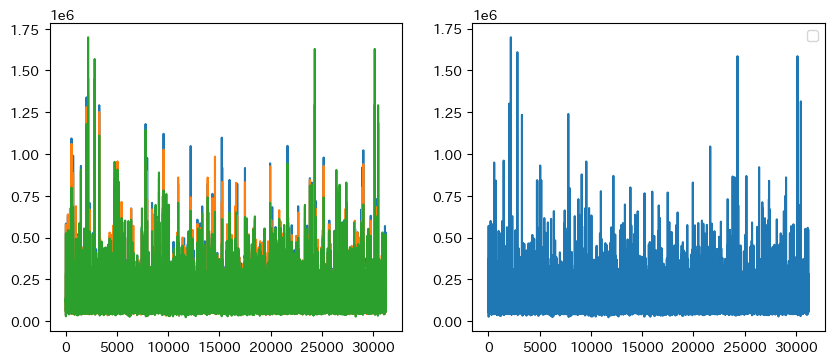

In [32]:
fig = plt.figure(figsize=(10,4))
ax = fig.add_subplot(121)
ax2 = fig.add_subplot(122)

ax.plot(range(len(blend_pred)), pred_LGBM, label='LGBM')
# ax.plot(range(len(blend_pred)), pred_DART, label='DART')
ax.plot(range(len(blend_pred)), pred_GOSS, label='GOSS')
ax.plot(range(len(blend_pred)), pred_XGB, label='XGB')

ax2.plot(range(len(blend_pred)), blend_pred)

plt.legend(loc='best')
plt.show()

ブレンドのモデルがLGBMの場合

In [26]:
# 個別のモデルの予測値たち。
valid_pred_LGBM = model_LGBM.predict(X_valid)
# valid_pred_DART = model_DART.predict(X_valid)
valid_pred_GOSS = model_GOSS.predict(X_valid)
valid_pred_XGB = xgb_reg.predict(X_valid)

# ブレンドの特徴量になるものをまとめる。
# stack_valid_pred = np.column_stack((valid_pred_LGBM,valid_pred_DART,valid_pred_GOSS,valid_pred_XGB))
stack_valid_pred = np.column_stack((valid_pred_LGBM,valid_pred_GOSS,valid_pred_XGB))

# ブレンドの作成。
blend_model = lgb.LGBMRegressor()
# ブレンドの特徴量として作ったデータと元データのy_validでブレンドを学習させる。
blend_model.fit(stack_valid_pred, y_valid)

# ここのモデルによるテストデータからの予測値
pred_LGBM = model_LGBM.predict(X_test)
# pred_DART = model_DART.predict(X_test)
pred_GOSS = model_GOSS.predict(X_test)
pred_XGB = xgb_reg.predict(X_test)

pred_LGBM = pd.DataFrame(pred_LGBM)
# pred_DART = pd.DataFrame(pred_DART)
pred_GOSS = pd.DataFrame(pred_GOSS)
pred_XGB = pd.DataFrame(pred_XGB)

#　ブレンドモデルのテストデータを作成
# stack_test_pred = np.column_stack((pred_LGBM, pred_DART, pred_GOSS, pred_XGB))
stack_test_pred = np.column_stack((pred_LGBM, pred_GOSS, pred_XGB))
print(stack_test_pred)

blend_pred = blend_model.predict(stack_test_pred)
blend_pred = pd.DataFrame(blend_pred)

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/sklearn/utils/validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[[138580.03774219 131631.84568007 118002.78125   ]
 [121670.7329273  121447.10733973 119678.2734375 ]
 [ 81581.16831512  83961.93487889  84770.125     ]
 ...
 [177533.51012032 174722.01942288 172593.78125   ]
 [264934.83305639 258337.94436019 277411.        ]
 [ 84175.95815483  82119.23128678  82911.5       ]]


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


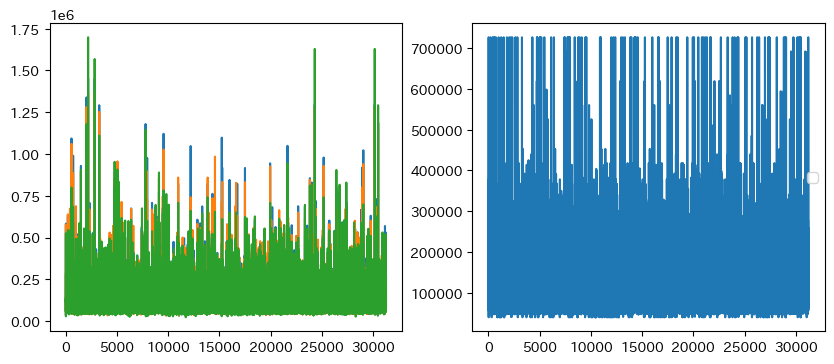

In [27]:
fig = plt.figure(figsize=(10,4))
ax = fig.add_subplot(121)
ax2 = fig.add_subplot(122)

ax.plot(range(len(blend_pred)), pred_LGBM, label='LGBM')
# ax.plot(range(len(blend_pred)), pred_DART, label='DART')
ax.plot(range(len(blend_pred)), pred_GOSS, label='GOSS')
ax.plot(range(len(blend_pred)), pred_XGB, label='XGB')

ax2.plot(range(len(blend_pred)), blend_pred)

plt.legend(loc='best')
plt.show()

ファイル出力

In [36]:
df = pd.read_csv('test.csv')
id = df['id']
y_pred = pd.DataFrame(blend_pred)
result = pd.concat([id, y_pred],axis=1)
result.to_csv('blend_result.csv',index=False)

lightGBMとDARTとGOSSとXGBoostでstackingアンサンブルを行う。(交差検証ver)

In [7]:
X_train = pd.concat([house_age, area_size, contract_span2, reg_rent, floor_scores2, Floor_scores2, stations, minits, addresses, room_arrange[["部屋数","L","D","K","S"]]], axis=1)
y_train = rent
X_test = pd.concat([test_house_age, test_area_size, test_contract_span2, test_reg_rent, test_floor_scores2, test_Floor_scores2, test_stations, test_minits, test_addresses, test_room_arrange[["部屋数","L","D","K","S"]]], axis=1)

#X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.2, random_state=0)
# sX_train, sX_valid, sy_train, sy_valid = train_test_split(X_train, y_train, test_size=0.1, random_state=0)

In [8]:
category_lists = ['定期借家','最寄り駅', '所在地', 'L', 'D','K','S']

cv = KFold(n_splits=5, shuffle=True, random_state=0)
for fold_id, (train_index, valid_index) in enumerate(cv.split(X_train)):
    X_tr = X_train.loc[train_index,:]
    X_val = X_train.loc[valid_index, :]
    y_tr = y_train.loc[train_index]
    y_val = y_train.loc[valid_index]
    sX_tr, sX_val, sy_tr, sy_val = train_test_split(X_tr, y_tr, test_size=0.1, random_state=0)

    ####LisgtGBM###
    lgb_train = lgb.Dataset(sX_tr, sy_tr)
    lgb_eval = lgb.Dataset(sX_val, sy_val, reference=lgb_train)
    params_LGBM = {
        'objective':'regression',
        'metrics':'rmse',
        'learning_rate':0.01,
        'reg_lambda': 4.430375245218262e-06,
        'max_bin': 502,
        'num_leaves': 97
    }
    model_LGBM = lgb.train(
                        params_LGBM,
                        lgb_train, 
                        valid_sets=[lgb_train, lgb_eval], 
                        verbose_eval=10, 
                        num_boost_round=3000, 
                        early_stopping_rounds=10,
                        categorical_feature = category_lists
                        )

    ###DART###
    lgb_train = lgb.Dataset(sX_tr, sy_tr)
    lgb_eval = lgb.Dataset(sX_val, sy_val, reference=lgb_train)
    params_DART = {
        'objective':'regression',
        'boosting_type':'dart',
        'metrics':'rmse',
        'learning_rate':0.05,
        'reg_lambda': 2.1600820741402023e-05,
        'max_bin': 556,
        'num_leaves': 126
    }

    model_DART = lgb.train(
                        params_DART,
                        lgb_train, 
                        valid_sets=[lgb_train, lgb_eval], 
                        verbose_eval=10, 
                        num_boost_round=1000, 
                        early_stopping_rounds=10,
                        categorical_feature = category_lists
                        )

    ###GOSS###
    lgb_train = lgb.Dataset(sX_tr, sy_tr)
    lgb_eval = lgb.Dataset(sX_val, sy_val, reference=lgb_train)
    params_GOSS = {
        'objective':'regression',
        'boosting_type':'goss',
        'metrics':'rmse',
        'learning_rate':0.01,
        'reg_lambda': 1.2667345328336822e-06,
        'max_bin': 405,
        'num_leaves': 118
    }

    model_GOSS = lgb.train(
                        params_GOSS,
                        lgb_train, 
                        valid_sets=[lgb_train, lgb_eval], 
                        verbose_eval=10, 
                        num_boost_round=1000, 
                        early_stopping_rounds=10,
                        categorical_feature = category_lists
                        )

    ###XGBoost###
    xgb_reg = xgboost.XGBRegressor(
        #目的関数の指定 初期値も二乗誤差です
                        objective='reg:linear',
                        #学習のラウンド数 early_stoppingを利用するので多めに指定
                        n_estimators=50000,
                        #boosterに何を用いるか 初期値もgbtreeです
                        booster='gbtree',
                        learning_rate=0.01,
                        max_depth=7,
                        random_state=0,
                        reg_alfa=6.8594164113286965e-06,
                        sub_sample=0.16056047423047484,
                        colsample_bytree=0.6987351856651322,
                        min_child_weight=1.1103525577197584
    )
    xgb_reg.fit(sX_tr, sy_tr, eval_set=[(sX_val, sy_val)], early_stopping_rounds=10)

_, X_valid, _, y_valid = train_test_split(X_train, y_train, test_size=0.2, random_state=0)
# 個別のモデルの予測値たち。
valid_pred_LGBM = model_LGBM.predict(X_valid)
valid_pred_DART = model_DART.predict(X_valid)
valid_pred_GOSS = model_GOSS.predict(X_valid)
valid_pred_XGB = xgb_reg.predict(X_valid)

# ブレンドの特徴量になるものをまとめる。
stack_valid_pred = np.column_stack((valid_pred_LGBM,valid_pred_DART,valid_pred_GOSS,valid_pred_XGB))

# ブレンドの作成。
blend_model = LinearRegression()

# ブレンドの特徴量として作ったデータと元データのy_validでブレンドを学習させる。
blend_model.fit(stack_valid_pred, y_valid)

# ここのモデルによるテストデータからの予測値
pred_LGBM = model_LGBM.predict(X_test)
pred_DART = model_DART.predict(X_test)
pred_GOSS = model_GOSS.predict(X_test)
pred_XGB = xgb_reg.predict(X_test)

pred_LGBM = pd.DataFrame(pred_LGBM)
pred_DART = pd.DataFrame(pred_DART)
pred_GOSS = pd.DataFrame(pred_GOSS)
pred_XGB = pd.DataFrame(pred_XGB)

#　ブレンドモデルのテストデータを作成
stack_test_pred = np.column_stack((pred_LGBM, pred_DART, pred_GOSS, pred_XGB))
print("ブレンドモデルに入れるテストデータ",stack_test_pred)

#ブレンドモデルによる最終の予測値
blend_pred = blend_model.predict(stack_test_pred)
blend_pred = pd.DataFrame(blend_pred)

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['D', 'K', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' ar

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001185 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2344
[LightGBM] [Info] Number of data points in the train set: 22658, number of used features: 14
[LightGBM] [Info] Start training from score 118553.622032
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 68405.3	valid_1's rmse: 64177.6
[20]	training's rmse: 63225.3	valid_1's rmse: 59165.3
[30]	training's rmse: 58581.9	valid_1's rmse: 54734.4
[40]	training's rmse: 54424.2	valid_1's rmse: 50902.2
[50]	training's rmse: 50688.8	valid_1's rmse: 47522.6
[60]	training's rmse: 47373.9	valid_1's rmse: 44536.2
[70]	training's rmse: 44348.7	valid_1's rmse: 41847
[80]	training's rmse: 41365.4	valid_1's rmse: 39189.1
[90]	training's rmse: 38616.6	valid_1's rmse: 36703.5
[100]	training's rmse: 36173.4	valid_1's 

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/callback.py:223: UserWarning: Early stopping is not available in dart mode
  _log_warning('Early stopping is not available in dart mode')


[10]	training's rmse: 52746.9	valid_1's rmse: 49256.4
[20]	training's rmse: 38964	valid_1's rmse: 36825.4
[30]	training's rmse: 30786.7	valid_1's rmse: 29813.9
[40]	training's rmse: 27345.1	valid_1's rmse: 27007.5
[50]	training's rmse: 30944.1	valid_1's rmse: 30339
[60]	training's rmse: 35246	valid_1's rmse: 35002.7
[70]	training's rmse: 37171.2	valid_1's rmse: 37152.8
[80]	training's rmse: 32038.9	valid_1's rmse: 32412.5
[90]	training's rmse: 32041.6	valid_1's rmse: 32213.3
[100]	training's rmse: 34063.2	valid_1's rmse: 34459.4
[110]	training's rmse: 40972.2	valid_1's rmse: 41011.9
[120]	training's rmse: 32560.7	valid_1's rmse: 33338.1
[130]	training's rmse: 29363.4	valid_1's rmse: 30404.5
[140]	training's rmse: 32195.2	valid_1's rmse: 33211.1
[150]	training's rmse: 30711.2	valid_1's rmse: 31876.7
[160]	training's rmse: 35464.2	valid_1's rmse: 36273.8
[170]	training's rmse: 28536.1	valid_1's rmse: 30190.1
[180]	training's rmse: 27278.5	valid_1's rmse: 29240
[190]	training's rmse: 2324

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[15]	validation_0-rmse:118749.24015
[16]	validation_0-rmse:117644.42360
[17]	validation_0-rmse:116574.03899
[18]	validation_0-rmse:115496.53102
[19]	validation_0-rmse:114422.63620
[20]	validation_0-rmse:113451.75668
[21]	validation_0-rmse:112417.18270
[22]	validation_0-rmse:111449.97436
[23]	validation_0-rmse:110442.16371
[24]	validation_0-rmse:109482.56931
[25]	validation_0-rmse:108492.70349
[26]	validation_0-rmse:107512.76561
[27]	validation_0-rmse:106594.49813
[28]	validation_0-rmse:105641.82052
[29]	validation_0-rmse:104704.69035
[30]	validation_0-rmse:103755.39458
[31]	validation_0-rmse:102890.61078
[32]	validation_0-rmse:102000.45018
[33]	validation_0-rmse:101078.34750
[34]	validation_0-rmse:100182.80196
[35]	validation_0-rmse:99329.91011
[36]	validation_0-rmse:98489.45612
[37]	validation_0-rmse:97617.50769
[38]	validation_0-rmse:96786.06841
[39]	validation_0-rmse:96006.85625
[40]	validation_0-rmse:95210.77289
[41]	validation_0-rmse:94407.31502
[42]	validation_0-rmse:93631.88684


/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['D', 'K', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' ar

Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 68448.1	valid_1's rmse: 64848
[20]	training's rmse: 63465.3	valid_1's rmse: 59807.9
[30]	training's rmse: 59047.8	valid_1's rmse: 55337.4
[40]	training's rmse: 55082.3	valid_1's rmse: 51319.1
[50]	training's rmse: 51557.3	valid_1's rmse: 47797.9
[60]	training's rmse: 48140.7	valid_1's rmse: 44420.1
[70]	training's rmse: 44995.7	valid_1's rmse: 41287.7
[80]	training's rmse: 42215.6	valid_1's rmse: 38540.2
[90]	training's rmse: 39726.5	valid_1's rmse: 36081.2
[100]	training's rmse: 37502.3	valid_1's rmse: 33887.5
[110]	training's rmse: 35497.5	valid_1's rmse: 31987.7
[120]	training's rmse: 33727.1	valid_1's rmse: 30448.5
[130]	training's rmse: 32151.5	valid_1's rmse: 29080.3
[140]	training's rmse: 30727.1	valid_1's rmse: 27837.7
[150]	training's rmse: 29414.3	valid_1's rmse: 26666
[160]	training's rmse: 28129.1	valid_1's rmse: 25398.8
[170]	training's rmse: 26934.2	valid_1's rmse: 24281.7
[180]	training's 

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/callback.py:223: UserWarning: Early stopping is not available in dart mode
  _log_warning('Early stopping is not available in dart mode')


[10]	training's rmse: 53337.6	valid_1's rmse: 51063.1
[20]	training's rmse: 39900.6	valid_1's rmse: 38101.9
[30]	training's rmse: 32584.7	valid_1's rmse: 30676.4
[40]	training's rmse: 29563.3	valid_1's rmse: 28006.9
[50]	training's rmse: 32847.7	valid_1's rmse: 31394.4
[60]	training's rmse: 36919.4	valid_1's rmse: 35818.7
[70]	training's rmse: 38783	valid_1's rmse: 37987.5
[80]	training's rmse: 33984.5	valid_1's rmse: 33274.7
[90]	training's rmse: 33886.2	valid_1's rmse: 33131.2
[100]	training's rmse: 35810.4	valid_1's rmse: 35182.9
[110]	training's rmse: 42369.7	valid_1's rmse: 41805
[120]	training's rmse: 34545.6	valid_1's rmse: 33973.6
[130]	training's rmse: 31528.2	valid_1's rmse: 31133.3
[140]	training's rmse: 34056	valid_1's rmse: 33531
[150]	training's rmse: 32609.1	valid_1's rmse: 32168.9
[160]	training's rmse: 37135.8	valid_1's rmse: 36729
[170]	training's rmse: 30592.9	valid_1's rmse: 30014.4
[180]	training's rmse: 29410.4	valid_1's rmse: 28823.5
[190]	training's rmse: 25704.

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[15]	validation_0-rmse:118463.26477
[16]	validation_0-rmse:117360.86363
[17]	validation_0-rmse:116263.75628
[18]	validation_0-rmse:115182.51834
[19]	validation_0-rmse:114125.70576
[20]	validation_0-rmse:113156.29234
[21]	validation_0-rmse:112128.78895
[22]	validation_0-rmse:111163.60426
[23]	validation_0-rmse:110143.64256
[24]	validation_0-rmse:109198.40660
[25]	validation_0-rmse:108204.77484
[26]	validation_0-rmse:107219.84218
[27]	validation_0-rmse:106313.55661
[28]	validation_0-rmse:105336.35982
[29]	validation_0-rmse:104454.15427
[30]	validation_0-rmse:103514.84884
[31]	validation_0-rmse:102647.70777
[32]	validation_0-rmse:101798.53011
[33]	validation_0-rmse:100886.81458
[34]	validation_0-rmse:100001.18500
[35]	validation_0-rmse:99170.36415
[36]	validation_0-rmse:98342.06214
[37]	validation_0-rmse:97460.29878
[38]	validation_0-rmse:96650.76065
[39]	validation_0-rmse:95871.89017
[40]	validation_0-rmse:95105.87797
[41]	validation_0-rmse:94339.88256
[42]	validation_0-rmse:93575.95713


/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['D', 'K', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' ar

[10]	training's rmse: 69019.2	valid_1's rmse: 58688.8
[20]	training's rmse: 63972.5	valid_1's rmse: 54204.5
[30]	training's rmse: 59502.8	valid_1's rmse: 50199
[40]	training's rmse: 55523	valid_1's rmse: 46601.1
[50]	training's rmse: 51951.4	valid_1's rmse: 43382
[60]	training's rmse: 48729	valid_1's rmse: 40397
[70]	training's rmse: 45814.3	valid_1's rmse: 37757.8
[80]	training's rmse: 42966.1	valid_1's rmse: 35468.5
[90]	training's rmse: 40421.2	valid_1's rmse: 33431.4
[100]	training's rmse: 38138.4	valid_1's rmse: 31638.7
[110]	training's rmse: 36062.4	valid_1's rmse: 30073.4
[120]	training's rmse: 34183.9	valid_1's rmse: 28656.1
[130]	training's rmse: 32524.8	valid_1's rmse: 27326.8
[140]	training's rmse: 31026.8	valid_1's rmse: 26169.7
[150]	training's rmse: 29533.6	valid_1's rmse: 24967.2
[160]	training's rmse: 28144.8	valid_1's rmse: 23895.5
[170]	training's rmse: 26915.9	valid_1's rmse: 22933.8
[180]	training's rmse: 25817.3	valid_1's rmse: 22133.7
[190]	training's rmse: 24843.

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/callback.py:223: UserWarning: Early stopping is not available in dart mode
  _log_warning('Early stopping is not available in dart mode')


[30]	training's rmse: 33425.6	valid_1's rmse: 27561.9
[40]	training's rmse: 30214.4	valid_1's rmse: 25207.9
[50]	training's rmse: 33262.7	valid_1's rmse: 28369.1
[60]	training's rmse: 37078.6	valid_1's rmse: 33083.9
[70]	training's rmse: 38866.4	valid_1's rmse: 35224.1
[80]	training's rmse: 34010.5	valid_1's rmse: 30599.4
[90]	training's rmse: 34003.4	valid_1's rmse: 30167.8
[100]	training's rmse: 35911.5	valid_1's rmse: 32410.2
[110]	training's rmse: 42497.5	valid_1's rmse: 38847.2
[120]	training's rmse: 34448.4	valid_1's rmse: 31274.7
[130]	training's rmse: 31432.9	valid_1's rmse: 28411.5
[140]	training's rmse: 34003.2	valid_1's rmse: 31319.3
[150]	training's rmse: 32573.4	valid_1's rmse: 29857.5
[160]	training's rmse: 37105.8	valid_1's rmse: 34256.5
[170]	training's rmse: 30448.4	valid_1's rmse: 28305.1
[180]	training's rmse: 29298.6	valid_1's rmse: 27277
[190]	training's rmse: 25539.4	valid_1's rmse: 23860.8
[200]	training's rmse: 24621.4	valid_1's rmse: 23015.3
[210]	training's rm

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[15]	validation_0-rmse:113769.74540
[16]	validation_0-rmse:112709.42474
[17]	validation_0-rmse:111651.48430
[18]	validation_0-rmse:110612.70442
[19]	validation_0-rmse:109579.85019
[20]	validation_0-rmse:108594.57750
[21]	validation_0-rmse:107598.74225
[22]	validation_0-rmse:106632.89135
[23]	validation_0-rmse:105655.19570
[24]	validation_0-rmse:104686.92627
[25]	validation_0-rmse:103728.69408
[26]	validation_0-rmse:102757.94525
[27]	validation_0-rmse:101830.31363
[28]	validation_0-rmse:100886.27709
[29]	validation_0-rmse:99966.88262
[30]	validation_0-rmse:99055.32647
[31]	validation_0-rmse:98184.31118
[32]	validation_0-rmse:97310.43634
[33]	validation_0-rmse:96424.35265
[34]	validation_0-rmse:95556.72726
[35]	validation_0-rmse:94697.95233
[36]	validation_0-rmse:93838.75738
[37]	validation_0-rmse:92982.81536
[38]	validation_0-rmse:92151.79453
[39]	validation_0-rmse:91373.38979
[40]	validation_0-rmse:90573.53932
[41]	validation_0-rmse:89782.01899
[42]	validation_0-rmse:89006.12303
[43]	v

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['D', 'K', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' ar

[10]	training's rmse: 69429.6	valid_1's rmse: 62378
[20]	training's rmse: 64356.4	valid_1's rmse: 57453.3
[30]	training's rmse: 59802.9	valid_1's rmse: 53020
[40]	training's rmse: 55758.6	valid_1's rmse: 49120.3
[50]	training's rmse: 52143.9	valid_1's rmse: 45637.9
[60]	training's rmse: 48882.4	valid_1's rmse: 42504
[70]	training's rmse: 45904.9	valid_1's rmse: 39707
[80]	training's rmse: 43066	valid_1's rmse: 37221.6
[90]	training's rmse: 40477.3	valid_1's rmse: 34963.4
[100]	training's rmse: 38126.2	valid_1's rmse: 32959.1
[110]	training's rmse: 36030.9	valid_1's rmse: 31119.2
[120]	training's rmse: 34163.3	valid_1's rmse: 29577.9
[130]	training's rmse: 32502.7	valid_1's rmse: 28206.4
[140]	training's rmse: 30962	valid_1's rmse: 26875.9
[150]	training's rmse: 29403.7	valid_1's rmse: 25533.7
[160]	training's rmse: 28096.7	valid_1's rmse: 24396.1
[170]	training's rmse: 26882.9	valid_1's rmse: 23332.4
[180]	training's rmse: 25845.3	valid_1's rmse: 22398.1
[190]	training's rmse: 24884.8	

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/callback.py:223: UserWarning: Early stopping is not available in dart mode
  _log_warning('Early stopping is not available in dart mode')


[30]	training's rmse: 33128.9	valid_1's rmse: 28587
[40]	training's rmse: 29944.4	valid_1's rmse: 25897.7
[50]	training's rmse: 33102.8	valid_1's rmse: 29173
[60]	training's rmse: 37061.4	valid_1's rmse: 33686.7
[70]	training's rmse: 38938.3	valid_1's rmse: 35769
[80]	training's rmse: 34097.7	valid_1's rmse: 30903.1
[90]	training's rmse: 34066.9	valid_1's rmse: 30633.3
[100]	training's rmse: 35931.8	valid_1's rmse: 32841.2
[110]	training's rmse: 42519.5	valid_1's rmse: 39420.9
[120]	training's rmse: 34402.2	valid_1's rmse: 31440.7
[130]	training's rmse: 31384	valid_1's rmse: 28395.6
[140]	training's rmse: 33991	valid_1's rmse: 31269.2
[150]	training's rmse: 32638.8	valid_1's rmse: 29825.3
[160]	training's rmse: 37197	valid_1's rmse: 34377.5
[170]	training's rmse: 30423.4	valid_1's rmse: 27999
[180]	training's rmse: 29315.9	valid_1's rmse: 26988
[190]	training's rmse: 25537.6	valid_1's rmse: 23337.6
[200]	training's rmse: 24580.7	valid_1's rmse: 22410.1
[210]	training's rmse: 26688.7	va

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[12]	validation_0-rmse:119850.95586
[13]	validation_0-rmse:118783.87147
[14]	validation_0-rmse:117718.20747
[15]	validation_0-rmse:116693.21623
[16]	validation_0-rmse:115600.52603
[17]	validation_0-rmse:114517.53035
[18]	validation_0-rmse:113460.23598
[19]	validation_0-rmse:112386.88669
[20]	validation_0-rmse:111408.22208
[21]	validation_0-rmse:110401.02757
[22]	validation_0-rmse:109420.01177
[23]	validation_0-rmse:108427.60835
[24]	validation_0-rmse:107473.60731
[25]	validation_0-rmse:106502.31433
[26]	validation_0-rmse:105502.78403
[27]	validation_0-rmse:104579.11275
[28]	validation_0-rmse:103622.74962
[29]	validation_0-rmse:102710.47753
[30]	validation_0-rmse:101774.12040
[31]	validation_0-rmse:100897.23187
[32]	validation_0-rmse:100020.62700
[33]	validation_0-rmse:99114.62017
[34]	validation_0-rmse:98225.90098
[35]	validation_0-rmse:97366.46229
[36]	validation_0-rmse:96530.41026
[37]	validation_0-rmse:95660.65760
[38]	validation_0-rmse:94835.53565
[39]	validation_0-rmse:94049.77878

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['D', 'K', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' ar

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001209 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2338
[LightGBM] [Info] Number of data points in the train set: 22658, number of used features: 14
[LightGBM] [Info] Start training from score 118196.819490
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 67461.1	valid_1's rmse: 69279.8
[20]	training's rmse: 62539	valid_1's rmse: 64334.8
[30]	training's rmse: 58153.9	valid_1's rmse: 59881.2
[40]	training's rmse: 54266.5	valid_1's rmse: 55896.4
[50]	training's rmse: 50790.6	valid_1's rmse: 52358
[60]	training's rmse: 47675.9	valid_1's rmse: 49153.9
[70]	training's rmse: 44882.6	valid_1's rmse: 46226
[80]	training's rmse: 42214.6	valid_1's rmse: 43869.7
[90]	training's rmse: 39751.3	valid_1's rmse: 41758.2
[100]	training's rmse: 37556.8	valid_1's rmse

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/callback.py:223: UserWarning: Early stopping is not available in dart mode
  _log_warning('Early stopping is not available in dart mode')


[30]	training's rmse: 33011.7	valid_1's rmse: 34926.2
[40]	training's rmse: 29991.5	valid_1's rmse: 32023.6
[50]	training's rmse: 33193.8	valid_1's rmse: 35385.8
[60]	training's rmse: 37205.4	valid_1's rmse: 39209.9
[70]	training's rmse: 38999.4	valid_1's rmse: 40772.2
[80]	training's rmse: 34237.1	valid_1's rmse: 36065.7
[90]	training's rmse: 34124.9	valid_1's rmse: 36112.3
[100]	training's rmse: 36063.5	valid_1's rmse: 37979.7
[110]	training's rmse: 42540.8	valid_1's rmse: 44289.2
[120]	training's rmse: 34733.8	valid_1's rmse: 36752.3
[130]	training's rmse: 31795.6	valid_1's rmse: 33804.1
[140]	training's rmse: 34269.2	valid_1's rmse: 36070.5
[150]	training's rmse: 32893.5	valid_1's rmse: 34735
[160]	training's rmse: 37350.3	valid_1's rmse: 39060
[170]	training's rmse: 30673.2	valid_1's rmse: 32580.9
[180]	training's rmse: 29480.5	valid_1's rmse: 31542
[190]	training's rmse: 25749.7	valid_1's rmse: 27876.1
[200]	training's rmse: 24736.9	valid_1's rmse: 26872.7
[210]	training's rmse: 

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[14]	validation_0-rmse:122841.38151
[15]	validation_0-rmse:121843.90147
[16]	validation_0-rmse:120759.59866
[17]	validation_0-rmse:119700.81831
[18]	validation_0-rmse:118638.89148
[19]	validation_0-rmse:117588.47097
[20]	validation_0-rmse:116633.53712
[21]	validation_0-rmse:115630.66502
[22]	validation_0-rmse:114691.44140
[23]	validation_0-rmse:113695.74792
[24]	validation_0-rmse:112782.37419
[25]	validation_0-rmse:111806.31184
[26]	validation_0-rmse:110836.46989
[27]	validation_0-rmse:109959.33543
[28]	validation_0-rmse:109015.40903
[29]	validation_0-rmse:108147.36478
[30]	validation_0-rmse:107214.59972
[31]	validation_0-rmse:106370.08313
[32]	validation_0-rmse:105533.91473
[33]	validation_0-rmse:104624.84196
[34]	validation_0-rmse:103740.08877
[35]	validation_0-rmse:102932.12688
[36]	validation_0-rmse:102120.08784
[37]	validation_0-rmse:101275.73485
[38]	validation_0-rmse:100490.58907
[39]	validation_0-rmse:99739.12659
[40]	validation_0-rmse:98975.28802
[41]	validation_0-rmse:98220.6

In [9]:
df = pd.read_csv('test.csv')
id = df['id']
y_pred = pd.DataFrame(blend_pred)
result = pd.concat([id, y_pred],axis=1)
result.to_csv('blend_result.csv',index=False)